# Ensemble Model
    - model : neural network
    - data : banksim
    - behavioural model : LOF model(novelty = True)

In [3]:
import os

In [4]:
computation = 'cloud'

In [5]:
if computation == 'local' :
    data_path = '../data/transaction_fraud/'
    global_model_path = '../models/globalmodel'
else :
    !pip install river
    !pip install imblearn
    !pip install xgboost
    from google.colab import drive
    drive.mount('/content/drive')
    data_path = '/content/drive/MyDrive/uco_fraud_detector/data/transaction_fraud/'
    global_model_path = '/content/drive/MyDrive/uco_fraud_detector/models/globalmodel'
print(f'data files : {os.listdir(data_path)}')
print(f'searching global model  : {os.path.exists(global_model_path)}')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
data files : ['bs140513_032310.csv', 'bsNET140513_032310.csv']
searching global model  : True


In [6]:
import numpy as np
import pandas as pd
import pickle
import os
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc, precision_recall_curve
from sklearn.model_selection import train_test_split

In [7]:
df = pd.read_csv(data_path + os.listdir(data_path)[0])
df.head()

,step,customer,age,gender,zipcodeOri,merchant,zipMerchant,category,amount,fraud
0,0,'C1093826151','4','M','28007','M348934600','28007','es_transportation',4.55,0
1,0,'C352968107','2','M','28007','M348934600','28007','es_transportation',39.68,0
2,0,'C2054744914','4','F','28007','M1823072687','28007','es_transportation',26.89,0
3,0,'C1760612790','3','M','28007','M348934600','28007','es_transportation',17.25,0
4,0,'C757503768','5','M','28007','M348934600','28007','es_transportation',35.72,0


In [8]:
file = open(global_model_path , 'rb')
global_model = pickle.load(file)
print(f'input_features : {global_model.input_features} \n')
print(f'categorical_features : {global_model.categorical_features} \n')
print(f'data_preprocessing_info : {global_model.data_preprocessing_info} \n')
print(f'label_encoders : {global_model.label_encoders} \n')

input_features : Index(['step', 'customer', 'age', 'gender', 'merchant', 'category', 'amount'], dtype='object') 

categorical_features : ['age', 'gender', 'category'] 

data_preprocessing_info : {'step': 'time from first transaction (int)(counter)', 'customer': 'frequency encoded account', 'age': 'label encoded (label encoder stored : le.transform(X[col])', 'gender': 'label encoded (label encoder stored : le.transform(X[col])', 'merchant': 'frequency encoded merchant account', 'category': 'label encoded (label encoder stored : le.transform(X[col])', 'amount': ''} 

label_encoders : {'age': LabelEncoder(), 'gender': LabelEncoder(), 'category': LabelEncoder()} 



In [ ]:
#making a database like data structure to store the LOFs for individual customers
lof_database = {}

## Data Preprocessing

In [9]:
# removing quotations from the datasets
for c in df.columns :
    if df[c].dtype==object :
        df[c] = df[c].replace("'","", regex = True)
df.head()

copy_df = df.copy()


#frequency encoding of the merchants and customer
for c in ['customer' , 'merchant'] :
    frequency = df[c].value_counts()
    df[c] = df[c].apply(lambda x : frequency[x])

# label encoding the categorical features according to the global model's label encoder
for c in global_model.categorical_features :
    df[c] = global_model.label_encoders[f'{c}'].transform(df[c])

df.insert(loc = 1,
          column = 'account_id',
          value = copy_df['customer'])

df.insert(loc=5,
          column='merchant_id',
          value = copy_df['merchant'])
#label encod the merchant_id column
import sklearn.preprocessing
le = sklearn.preprocessing.LabelEncoder()
df['merchant_id'] = le.fit_transform(df['merchant_id'])

df.head()

df = df.drop(['zipcodeOri' , 'zipMerchant'] , axis = 1)


df.head()

,step,account_id,customer,age,gender,merchant_id,merchant,category,amount,fraud
0,0,C1093826151,167,4,2,30,205426,12,4.55,0
1,0,C352968107,169,2,2,30,205426,12,39.68,0
2,0,C2054744914,65,4,1,18,299693,12,26.89,0
3,0,C1760612790,171,3,2,30,205426,12,17.25,0
4,0,C757503768,145,5,2,30,205426,12,35.72,0


## ..


In [10]:
localization_test = True

## Test for category localization

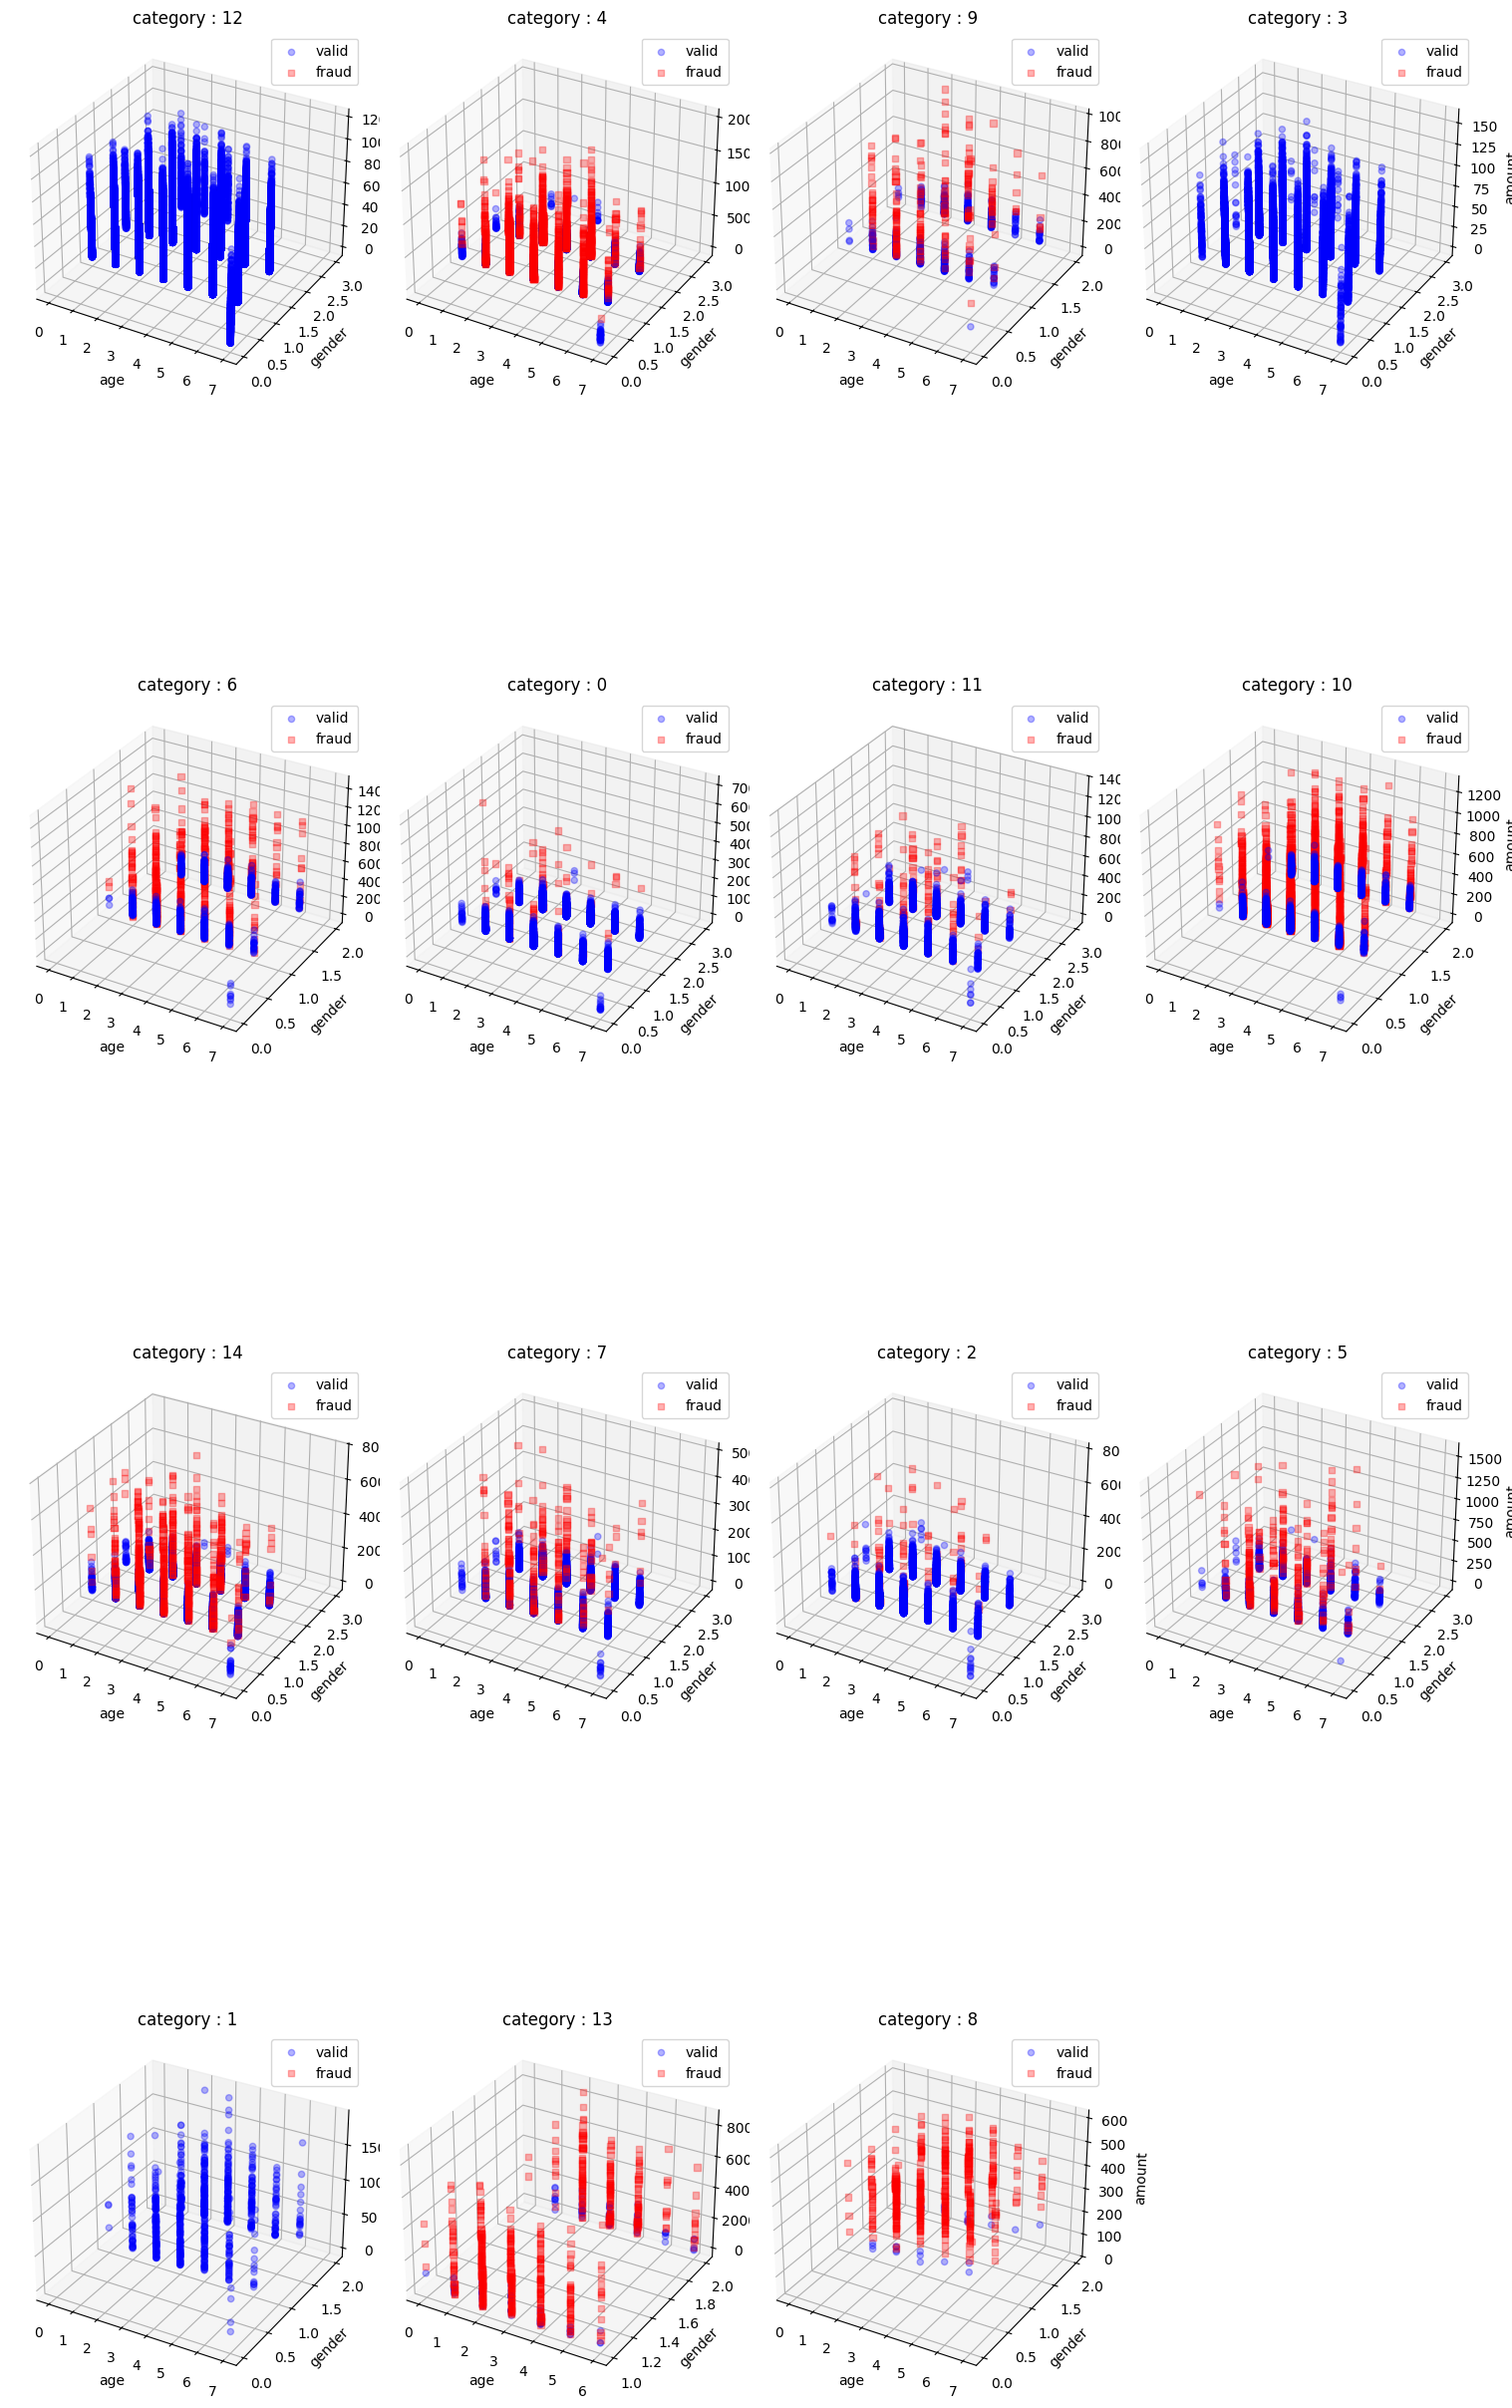

In [11]:
#   fig = plt.figure(figsize=(7, 6))
#   ax = fig.add_subplot(111, projection='3d')
#   ax.scatter(df['age'][df['category']==category][df['fraud']==0],df['gender'][df['category']==category][df['fraud']==0],df['amount'][df['category']==category][df['fraud']==0], marker='o',color='b',alpha=0.3)
#   ax.scatter(df['age'][df['category']==category][df['fraud']==1],df['gender'][df['category']==category][df['fraud']==1],df['amount'][df['category']==category][df['fraud']==1], marker='s',color='r',alpha=0.3)
#   ax.set_xlabel('age')
#   ax.set_ylabel('gender')
#   ax.set_zlabel('amount')
#   ax.set_title(f'category : {category}')
#   plt.legend(['valid','fraud'])
#   plt.show()

if localization_test :
  num_categories = len(df['category'].unique())
  n_cols = 4
  n_rows = (num_categories + n_cols - 1) // n_cols

  fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 7 * n_rows), subplot_kw={'projection': '3d'})
  axes = axes.flatten()
  for i, category in enumerate(df['category'].unique()):
      ax = axes[i]
      ax.scatter(df['age'][df['category']==category][df['fraud']==0],df['gender'][df['category']==category][df['fraud']==0],df['amount'][df['category']==category][df['fraud']==0], marker='o',color='b',alpha=0.3)
      ax.scatter(df['age'][df['category']==category][df['fraud']==1],df['gender'][df['category']==category][df['fraud']==1],df['amount'][df['category']==category][df['fraud']==1], marker='s',color='r',alpha=0.3)
      ax.set_xlabel('age')
      ax.set_ylabel('gender')
      ax.set_zlabel('amount')
      ax.set_title(f'category : {category}')
      ax.legend(['valid','fraud'])

  for j in range(num_categories, n_rows * n_cols):
      fig.delaxes(axes[j])

  plt.tight_layout()
  plt.show()


Therefore we cannot localize onthe basis of category

## Test for account localization

In [ ]:
# accounts = df['account_id'].unique()
# for a in accounts :
#   data = df[df['account_id']==a]
#   if not data['fraud'].any() :
#     continue
#   fig, ax = plt.subplots()
#   fig.set_size_inches(3, 2)
#   ax.scatter(data['category'][data['fraud']==0],data['amount'][data['fraud']==0],marker='o',color='b',alpha=0.3)
#   ax.scatter(data['category'][data['fraud']==1],data['amount'][data['fraud']==1],marker='s',color='r',alpha=1)
#   ax.set_xlabel('category')
#   ax.set_ylabel('amount')
#   ax.set_title(f'account_id : {a}')
#   plt.legend(['valid','fraud'])
#   plt.show()

if localization_test :
  accounts = df['account_id'].unique()
  num_accounts_with_fraud = sum(1 for a in accounts if df[df['account_id']==a]['fraud'].any())
  n_cols = 5
  n_rows = (num_accounts_with_fraud + n_cols - 1) // n_cols

  fig, axes = plt.subplots(n_rows, n_cols, figsize=(3 * n_cols, 2 * n_rows))
  axes = axes.flatten()

  plot_index = 0
  for a in accounts:
      data = df[df['account_id']==a]
      if not data['fraud'].any():
          continue

      ax = axes[plot_index]
      ax.scatter(data['category'][data['fraud']==0],data['amount'][data['fraud']==0],marker='o',color='b',alpha=0.3)
      ax.scatter(data['category'][data['fraud']==1],data['amount'][data['fraud']==1],marker='s',color='r',alpha=1)
      ax.set_xlabel('category')
      ax.set_ylabel('amount')
      ax.set_title(f'account_id : {a}')
      ax.legend(['valid','fraud'])
      plot_index += 1

  # Hide any unused subplots
  for j in range(plot_index, n_rows * n_cols):
      fig.delaxes(axes[j])

  plt.tight_layout()
  plt.show()

So, account localization may be possible

## Splitting dataset

In [ ]:
df['account_id'].nunique()

4112

In [ ]:
total_sample = df.shape[0]
feed_index = (int)(total_sample * 0.25)
train_index = (int) (feed_index + (total_sample * 0.6))
test_index = total_sample
print(f'feed_index : {feed_index}')
print(f'train_index : {train_index}')
print(f'test_index : {test_index}')

feed_index : 148660
train_index : 505445
test_index : 594643


In [ ]:
# split the dataset accordingly
feed_df = df.iloc[:feed_index , :]
train_df = df.iloc[feed_index + 1 : train_index , :]
test_df = df.iloc[train_index + 1 : ,:]
print(f'feed_df length: {feed_df.shape[0]}')
print(f'train_df length: {train_df.shape[0]}')
print(f'test_df length: {test_df.shape[0]}')

feed_df length: 148660
train_df length: 356784
test_df length: 89197


In [ ]:
feed_df['account_id'].nunique()

4077

## Feeding Data
 - Making the lof models

In [ ]:
# make the LOF models for all the customer
from river import anomaly
accounts = df['account_id'].unique()
for a in accounts :
    lof_database[f'{a}'] = anomaly.LocalOutlierFactor(n_neighbors = 15)
print('Created lof models for all customer (ONE TIME PROCESS)')


Created lof models for all customer (ONE TIME PROCESS)


In [ ]:
feed_df.head()

,step,account_id,customer,age,gender,merchant_id,merchant,category,amount,fraud
0,0,C1093826151,167,4,2,30,205426,12,4.55,0
1,0,C352968107,169,2,2,30,205426,12,39.68,0
2,0,C2054744914,65,4,1,18,299693,12,26.89,0
3,0,C1760612790,171,3,2,30,205426,12,17.25,0
4,0,C757503768,145,5,2,30,205426,12,35.72,0


In [ ]:
# feeding data
copy_feed_df = feed_df.drop(['step','customer','age','gender','merchant'],axis = 1)
for i in range(feed_df.shape[0]):
    data = copy_feed_df.iloc[i]
    account_id = data['account_id']
    is_fraud = data['fraud']
    if is_fraud != 1 :
      data = data.drop(['account_id','fraud'])
      assert data.shape[0] == 3
      data = data.to_dict()
      lof_database[f'{account_id}'].learn_one(data)
print('fed data to all the lofs')

fed data to all the lofs


In [ ]:
lof_info = {
    'n_neighbors' : 15,
    'input_features' : ['merchant_id','category', 'amount'],
    'feature_details' : {
        'merchant_id' : 'label encoded merchant id (label encoder stored : merchant_label_encoder)',
        'category' : 'label encoded category features(from global model (use label encoder of global model)',
        'amount' : 'transaction value (donot scale yet , input unscaled data)',
    }
}
lof_database['merchant_label_encoder'] = le
lof_database['info'] = lof_info

## Create Ensemble data
 - output from global model
 - output from lof model

In [ ]:
ensemble_df = pd.DataFrame()

In [ ]:
train_df.head()

,step,account_id,customer,age,gender,merchant_id,merchant,category,amount,fraud
148661,52,C1389311354,173,5,2,18,299693,12,7.58,0
148662,52,C1035666255,170,2,2,11,2624,2,25.41,0
148663,52,C529952024,164,2,2,18,299693,12,35.32,0
148664,52,C1272188168,171,5,1,30,205426,12,2.55,0
148665,52,C1769359992,167,3,1,30,205426,12,24.31,0


- we need to create data for global transaction model
- we need to create data for LOF model

### Data from global model

In [ ]:
global_model

StackingClassifier(estimators=[('rf',
                                RandomForestClassifier(max_depth=14,
                                                       min_samples_split=16,
                                                       n_estimators=389,
                                                       random_state=16))],
                   final_estimator=XGBClassifier(base_score=None, booster=None,
                                                 callbacks=None,
                                                 colsample_bylevel=None,
                                                 colsample_bynode=None,
                                                 colsample_bytree=None,
                                                 device=None,
                                                 early_stopping_rounds=None,
                                                 enable_categorical=False,
                                                 eval_metric='au...
                                                 feature_weights=None,
                                                 gamma=None, grow_policy=None,
                                                 importance_type=None,
                                                 interaction_constraints=None,
                                                 learning_rate=0.1,
                                                 max_bin=None,
                                                 max_cat_threshold=None,
                                                 max_cat_to_onehot=None,
                                                 max_delta_step=None,
                                                 max_depth=7, max_leaves=None,
                                                 min_child_weight=None,
                                                 missing=nan,
                                                 monotone_constraints=None,
                                                 multi_strategy=None,
                                                 n_estimators=400, n_jobs=None,
                                                 num_parallel_tree=None, ...))

In [ ]:
global_model.input_features

Index(['step', 'customer', 'age', 'gender', 'merchant', 'category', 'amount'], dtype='object')

In [ ]:
global_model_df = train_df.drop(['account_id' ,'merchant_id', 'fraud'],axis=1)
global_model_df.head()

,step,customer,age,gender,merchant,category,amount
148661,52,173,5,2,299693,12,7.58
148662,52,170,2,2,2624,2,25.41
148663,52,164,2,2,299693,12,35.32
148664,52,171,5,1,205426,12,2.55
148665,52,167,3,1,205426,12,24.31


In [ ]:
global_output = global_model.predict_proba(global_model_df)
print(global_output)

[[9.9999857e-01 1.4420659e-06]
 [9.9999857e-01 1.4420659e-06]
 [9.9999857e-01 1.4420659e-06]
 ...
 [9.9999857e-01 1.4420659e-06]
 [9.9999857e-01 1.4420659e-06]
 [9.9999857e-01 1.4420659e-06]]


In [ ]:
ensemble_df[['g_output_valid' , 'g_output_fraud']] = global_output
ensemble_df.head()

,g_output_valid,g_output_fraud
0,0.999999,0.000001
1,0.999999,0.000001
2,0.999999,0.000001
3,0.999999,0.000001
4,0.999999,0.000001


In [ ]:
ensemble_df = ensemble_df.drop('g_output_valid',axis =1)
ensemble_df.head()

,g_output_fraud
0,0.000001
1,0.000001
2,0.000001
3,0.000001
4,0.000001


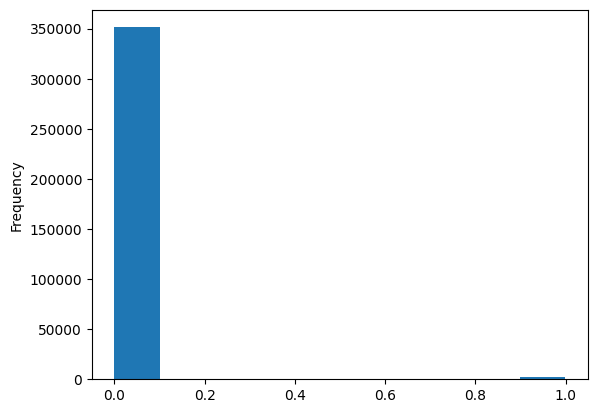

In [ ]:
ensemble_df['g_output_fraud'].plot.hist()
plt.show()

### Data from LOF models

In [ ]:
lof_database['info']['input_features']

['merchant_id', 'category', 'amount']

In [ ]:
train_df.head()

,step,account_id,customer,age,gender,merchant_id,merchant,category,amount,fraud
148661,52,C1389311354,173,5,2,18,299693,12,7.58,0
148662,52,C1035666255,170,2,2,11,2624,2,25.41,0
148663,52,C529952024,164,2,2,18,299693,12,35.32,0
148664,52,C1272188168,171,5,1,30,205426,12,2.55,0
148665,52,C1769359992,167,3,1,30,205426,12,24.31,0


In [ ]:
from river import anomaly
lof_scores = []
for i in range(train_df.shape[0]) :
    account_id = train_df.iloc[i]['account_id']
    is_fraud = train_df.iloc[i]['fraud']
    if f'{account_id}' not in lof_database :
        lof_database[f'{account_id}'] = anomaly.LocalOutlierFactor(n_neighbors = 15)
    data = train_df.iloc[i].drop(['step','account_id','customer','age','gender','merchant','fraud'])
    data = data.to_dict()

    lof_scores.append(lof_database[f'{account_id}'].score_one(data))
    if is_fraud == 0 :
        lof_database[f'{account_id}'].learn_one(data)

print(lof_scores[:5])

[1.0132187630223484, 3.604199083113572, 1.0741643976091808, 1.073495411809012, 0.9732040254138685]


In [ ]:
lof_database['feeded_index'] = train_index

In [ ]:
lof_database_save_path = '/content/drive/MyDrive/uco_fraud_detector/models/lof_database'
file = open(lof_database_save_path , 'wb')
pickle.dump(lof_database, file)
print('saved lof database')

saved lof database


In [ ]:
print("Searching for lof_database : " , 'found' if os.path.exists(lof_database_save_path) else 'not found')

Searching for lof_database :  found


In [ ]:
lof_database1 = pickle.load(open(lof_database_save_path , 'rb'))
lof_database1['merchant_label_encoder']

LabelEncoder()

In [ ]:
print(len(lof_scores))
print(ensemble_df.shape[0])

356784
356784


In [ ]:
num_cols = 1
lof_scores_2d = np.array(lof_scores).reshape(ensemble_df.shape[0],num_cols)
print(lof_scores_2d.shape)

(356784, 1)


In [ ]:
ensemble_df[['lof_scores']] = lof_scores_2d
ensemble_df.head()

,g_output_fraud,lof_scores
0,0.000001,1.013219
1,0.000001,3.604199
2,0.000001,1.074164
3,0.000001,1.073495
4,0.000001,0.973204


In [ ]:
fraud_array = train_df['fraud'].to_numpy()
fraud_array = fraud_array.reshape(fraud_array.shape[0],1)
print(fraud_array.shape)

(356784, 1)


In [ ]:
ensemble_df['fraud'] = fraud_array
ensemble_df.head()

,g_output_fraud,lof_scores,fraud
0,0.000001,1.013219,0
1,0.000001,3.604199,0
2,0.000001,1.074164,0
3,0.000001,1.073495,0
4,0.000001,0.973204,0


### General data

In [ ]:
cat_values = np.array(train_df['category']).reshape(train_df.shape[0],1)
amount_values = np.array(train_df['amount']).reshape(train_df.shape[0],1)
ensemble_df.insert(loc=0,
                   column='category',
                   value = cat_values)
ensemble_df.insert(loc=1,
                   column='amount',
                   value = amount_values)
#scale amount data
from sklearn.preprocessing import StandardScaler
amount_scaler = StandardScaler()
ensemble_df['amount'] = amount_scaler.fit_transform(ensemble_df['amount'].values.reshape(-1,1))
ensemble_df.head()

,category,amount,g_output_fraud,lof_scores,fraud
0,12,-0.279633,0.000001,1.013219,0
1,2,-0.113380,0.000001,3.604199,0
2,12,-0.020976,0.000001,1.074164,0
3,12,-0.326535,0.000001,1.073495,0
4,12,-0.123637,0.000001,0.973204,0


### saving ensemble data

In [ ]:
save_data_path = '/content/drive/MyDrive/uco_fraud_detector/data/'
if not os.path.exists(save_data_path):
    os.makedirs(save_data_path)
ensemble_df.to_csv(save_data_path + 'ensemble_train_data_2.csv',index=False)

 now the data is ready .

## Training Ensemble

In [ ]:
def evaluate_model(model,
                   model_name,
                   X_train,
                   Y_train,
                   X_test,
                   Y_test) :
    model.fit(X_train, Y_train)
    y_cap = model.predict(X_test)
    print(f'Evaluation_for {model_name}: ')
    print(classification_report(Y_test, y_cap))
    conf_mat = confusion_matrix(Y_test, y_cap)
    plt.figure(figsize = (5,5))
    sns.heatmap(conf_mat, annot = True,fmt = 'd', cmap = 'plasma')
    plt.title(f'Confusion Matrix for {model_name}')
    plt.xlabel('y_cap')
    plt.ylabel('y_test')
    plt.show()

    #ROC curve and the area under curve
    y_score = model.predict_proba(X_test)[:,1]
    false_pos_rate , true_pos_rate, thr = roc_curve(Y_test, y_score)
    roc_auc = auc(false_pos_rate , true_pos_rate)

    plt.figure(figsize = (7,5))
    plt.plot(false_pos_rate, true_pos_rate, label = f'ROC Curve, area = {roc_auc:.3f}')
    plt.plot([0,1] , [0,1] , linestyle = '--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve for {model_name}')
    plt.legend(loc='lower right')
    plt.show()

    #Precision-Recall curve Nad AUC
    precision, recall, thresholds = precision_recall_curve(Y_test, y_score)
    pr_auc = auc(recall, precision)

    plt.figure(figsize=(7, 5))
    plt.plot(recall, precision, label=f'PR Curve (area = {pr_auc:.2f})')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title(f'Precision-Recall Curve for {model_name}')
    plt.legend(loc='best')
    plt.show()
    return model

In [ ]:
ensemble_data_path = '/content/drive/MyDrive/uco_fraud_detector/data/ensemble_train_data_2.csv'
ensemble_df1 = pd.read_csv(ensemble_data_path)
ensemble_df1.head()

,category,amount,g_output_fraud,lof_scores,fraud
0,12,-0.279633,0.000001,1.013219,0
1,2,-0.113380,0.000001,3.604199,0
2,12,-0.020976,0.000001,1.074164,0
3,12,-0.326535,0.000001,1.073495,0
4,12,-0.123637,0.000001,0.973204,0


In [ ]:
ensemble_df.head()

,category,amount,g_output_fraud,lof_scores,fraud
0,12,-0.279633,0.000001,1.013219,0
1,2,-0.113380,0.000001,3.604199,0
2,12,-0.020976,0.000001,1.074164,0
3,12,-0.326535,0.000001,1.073495,0
4,12,-0.123637,0.000001,0.973204,0


### EDA

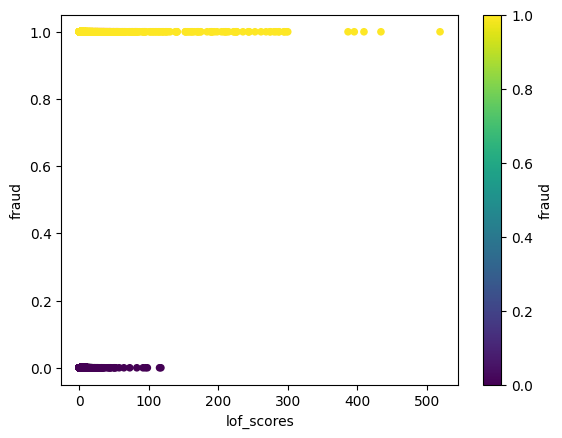

In [ ]:
ensemble_df.plot.scatter(x = 'lof_scores',y = 'fraud',c = 'fraud',colormap = 'viridis')
plt.show()

from the above graph it is very clear that novelty detection is working nicely , the outlier data points which are the frauds in this case are nicely being scored.

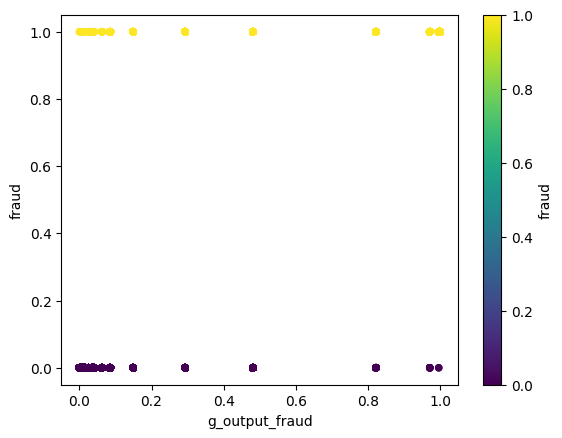

In [ ]:
ensemble_df.plot.scatter(x = 'g_output_fraud',y = 'fraud',c = 'fraud',colormap = 'viridis')
plt.show()

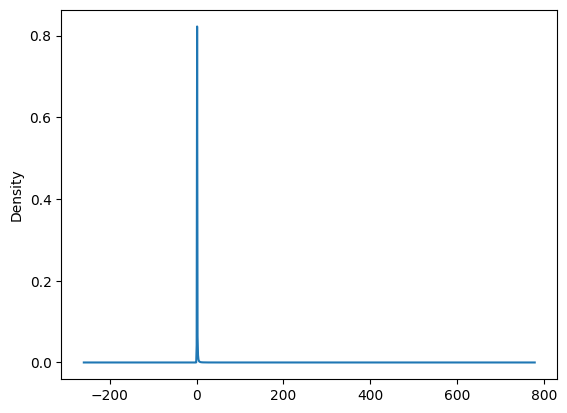

In [ ]:
ensemble_df['lof_scores'].plot.density()
plt.show()

now we will seee the correlation matrix for similarities in the features

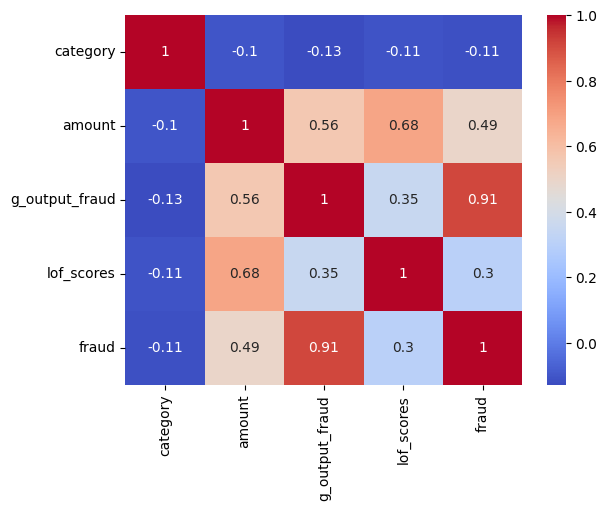

In [ ]:
corr_matrix = ensemble_df.corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.show()

now. we will choose the model that perfectly does the jod, but before that we need to split the data

In [ ]:
X = ensemble_df.drop('fraud',axis=1)
Y = ensemble_df['fraud']
X_train,X_test,y_train,y_test = train_test_split(X, Y,
                                                  test_size=0.3,
                                                  random_state=16)

In [ ]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(249748, 4)
(249748,)
(107036, 4)
(107036,)


### Logistic regression

Evaluation_for Logistic Regression: 
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    105783
           1       0.93      0.84      0.88      1253

    accuracy                           1.00    107036
   macro avg       0.96      0.92      0.94    107036
weighted avg       1.00      1.00      1.00    107036



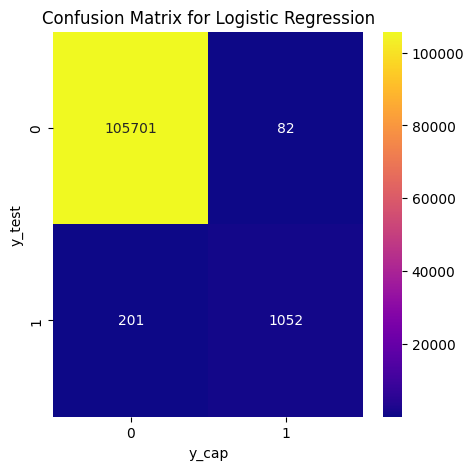

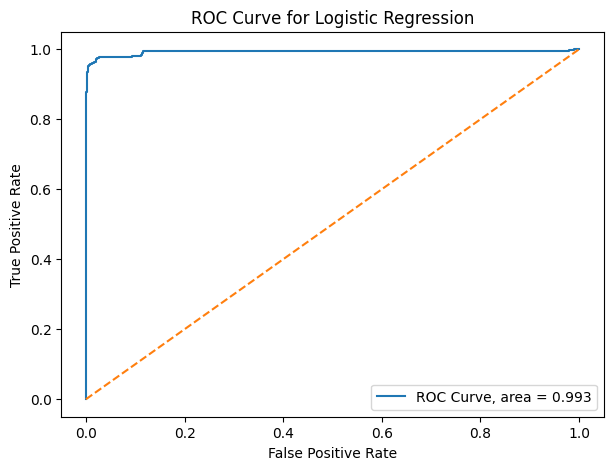

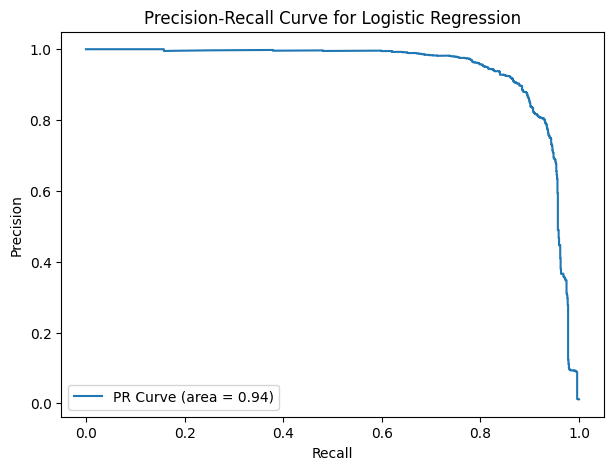

In [ ]:
from sklearn.linear_model import LogisticRegression
evaluate_model(LogisticRegression(),
               'Logistic Regression',
               X_train,
               y_train,
               X_test,
               y_test)

### Random Forest

Evaluation_for Random Forest: 
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    105783
           1       0.91      0.87      0.89      1253

    accuracy                           1.00    107036
   macro avg       0.95      0.93      0.94    107036
weighted avg       1.00      1.00      1.00    107036



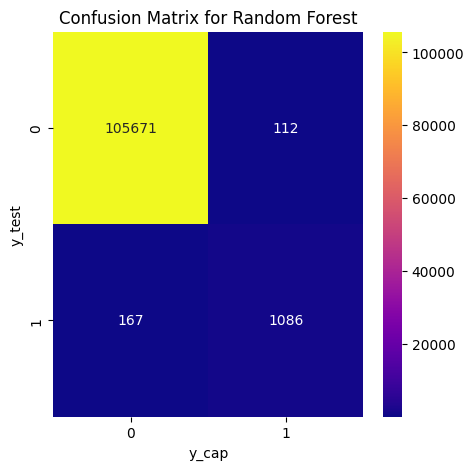

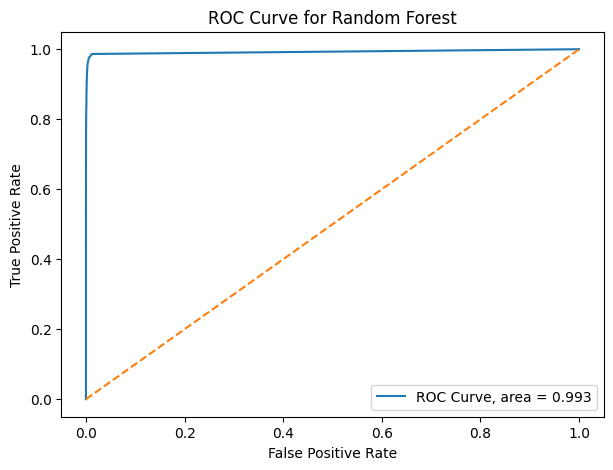

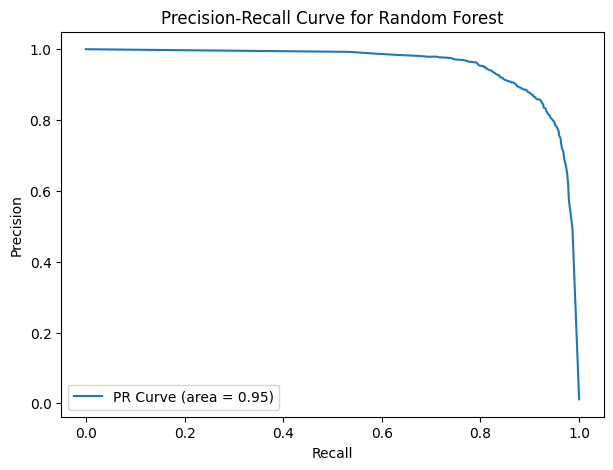

In [ ]:
from sklearn.ensemble import RandomForestClassifier
evaluate_model(RandomForestClassifier(),
               'Random Forest',
               X_train,
               y_train,
               X_test,
               y_test)

### XGBoost

Evaluation_for XGBoost: 
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    105783
           1       0.91      0.87      0.89      1253

    accuracy                           1.00    107036
   macro avg       0.96      0.93      0.94    107036
weighted avg       1.00      1.00      1.00    107036



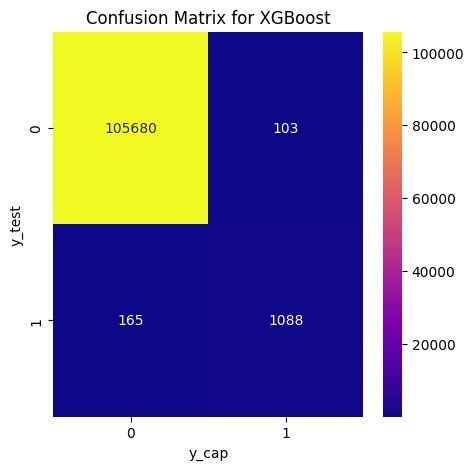

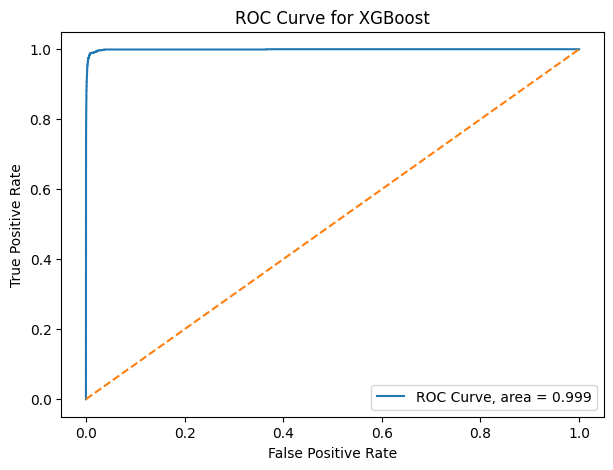

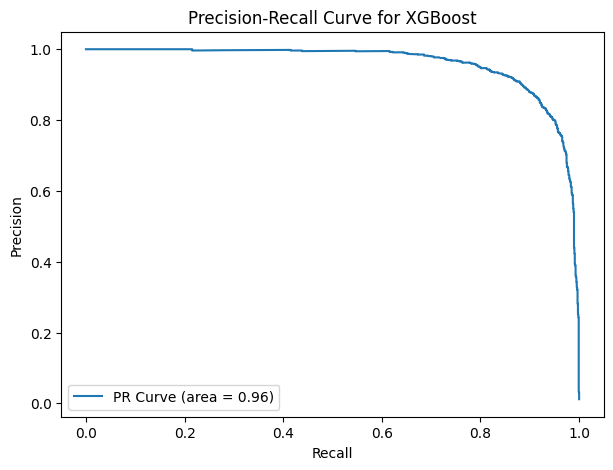

In [ ]:
from xgboost import XGBClassifier
evaluate_model(XGBClassifier(),
               'XGBoost',
               X_train,
               y_train,
               X_test,
               y_test)

### neural Network

Evaluation_for Neural Network: 
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    105783
           1       0.89      0.90      0.89      1253

    accuracy                           1.00    107036
   macro avg       0.94      0.95      0.95    107036
weighted avg       1.00      1.00      1.00    107036



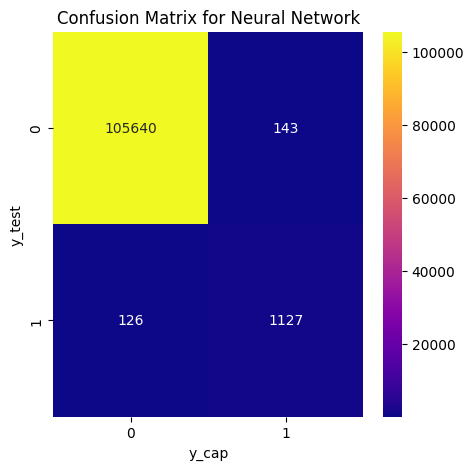

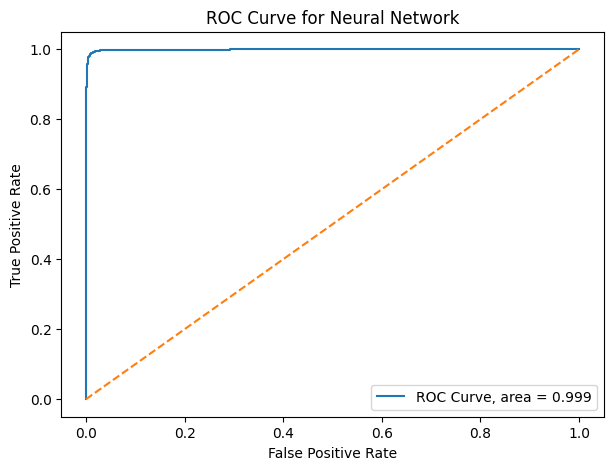

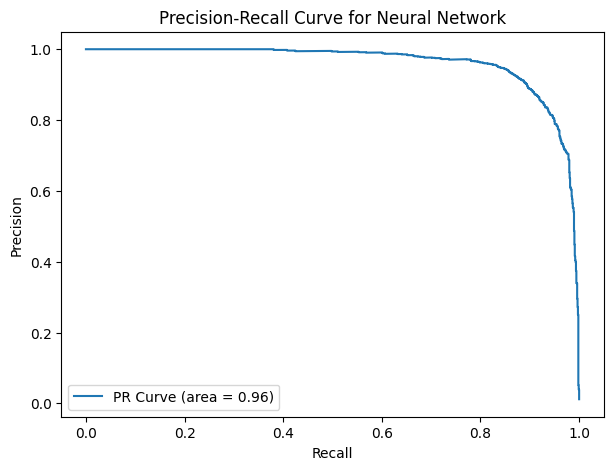

In [ ]:
from sklearn.neural_network import MLPClassifier
nn_model = evaluate_model(MLPClassifier(hidden_layer_sizes = (10,100)),
               'Neural Network',
               X_train,
               y_train,
               X_test,
               y_test)

### AdaBoost Classifier

Evaluation_for AdaBoost Classifier: 
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    105783
           1       0.90      0.88      0.89      1253

    accuracy                           1.00    107036
   macro avg       0.95      0.94      0.94    107036
weighted avg       1.00      1.00      1.00    107036



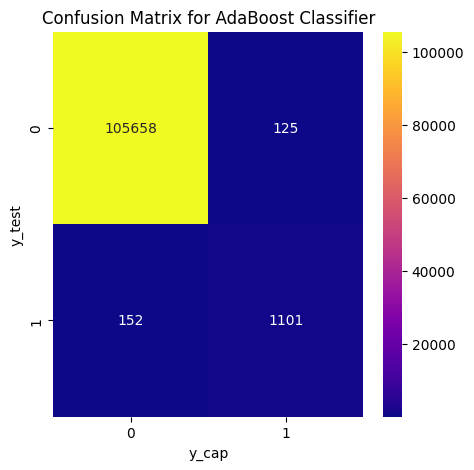

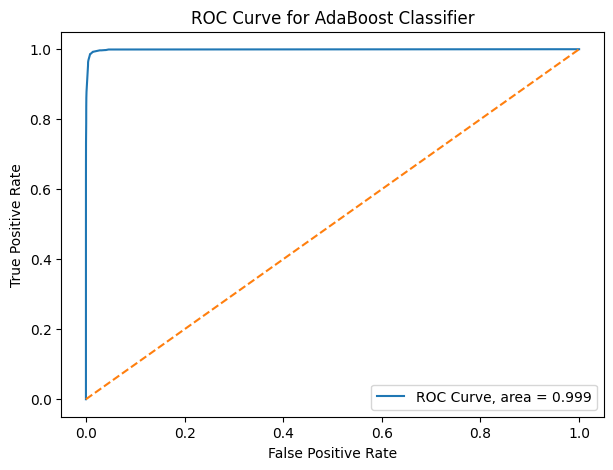

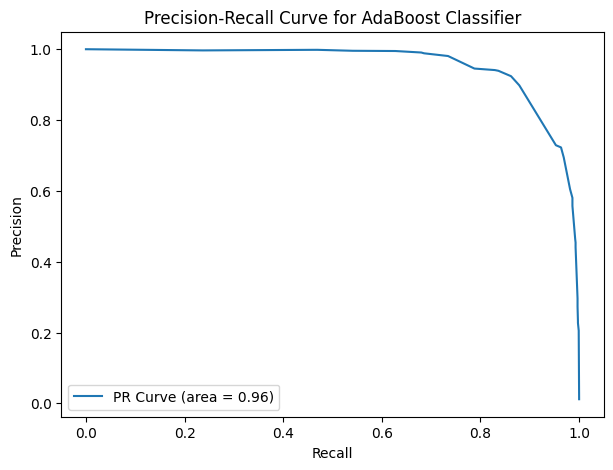

In [ ]:
from sklearn.ensemble import AdaBoostClassifier
evaluate_model(AdaBoostClassifier(),
               'AdaBoost Classifier',
               X_train,
               y_train,
               X_test,
               y_test)

### saving ensemble model
the neural network performs best in this situation, we will use the neural network for the final ensemble.**bold text**

In [ ]:
ensemble_model = MLPClassifier(hidden_layer_sizes = (10,100,))
ensemble_model.fit(X_train,y_train)
ensemble_model.amount_scaler = amount_scaler
ensemble_model.lof_info = lof_info

In [ ]:
ensemble_save_path = '/content/drive/MyDrive/uco_fraud_detector/models/ensemblemodel_2'
file = open(ensemble_save_path , 'wb')
pickle.dump(nn_model, file)
print('saved ensemble model')

saved ensemble model


testing ensemble model on entire ensemble_df

In [ ]:
ensemble_model = pickle.load(open('/content/drive/MyDrive/uco_fraud_detector/models/ensemblemodel_2' , 'rb'))
ensemble_model

MLPClassifier(hidden_layer_sizes=(10, 100))

In [ ]:
y_cap = ensemble_model.predict(ensemble_df.drop('fraud',axis=1))
y_test = ensemble_df['fraud']
print(classification_report(y_test, y_cap))
confusion_matrix(y_test , y_cap)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    352650
           1       0.92      0.87      0.90      4134

    accuracy                           1.00    356784
   macro avg       0.96      0.93      0.95    356784
weighted avg       1.00      1.00      1.00    356784



array([[352355,    295],
       [   537,   3597]])

## Testing



In [ ]:
ensemble_save_path = '/content/drive/MyDrive/uco_fraud_detector/models/ensemblemodel_2'
file = open(ensemble_save_path , 'rb')
ensemble_model = pickle.load(file)
print('loaded ensemble model')
ensemble_model

loaded ensemble model


MLPClassifier(hidden_layer_sizes=(10, 100))

In [ ]:
global_model_save_path = '/content/drive/MyDrive/uco_fraud_detector/models/globalmodel'
file = open(global_model_save_path , 'rb')
global_model = pickle.load(file)
print('loaded global model')
global_model

loaded global model


StackingClassifier(estimators=[('rf',
                                RandomForestClassifier(max_depth=14,
                                                       min_samples_split=16,
                                                       n_estimators=389,
                                                       random_state=16))],
                   final_estimator=XGBClassifier(base_score=None, booster=None,
                                                 callbacks=None,
                                                 colsample_bylevel=None,
                                                 colsample_bynode=None,
                                                 colsample_bytree=None,
                                                 device=None,
                                                 early_stopping_rounds=None,
                                                 enable_categorical=False,
                                                 eval_metric='au...
                                                 feature_weights=None,
                                                 gamma=None, grow_policy=None,
                                                 importance_type=None,
                                                 interaction_constraints=None,
                                                 learning_rate=0.1,
                                                 max_bin=None,
                                                 max_cat_threshold=None,
                                                 max_cat_to_onehot=None,
                                                 max_delta_step=None,
                                                 max_depth=7, max_leaves=None,
                                                 min_child_weight=None,
                                                 missing=nan,
                                                 monotone_constraints=None,
                                                 multi_strategy=None,
                                                 n_estimators=400, n_jobs=None,
                                                 num_parallel_tree=None, ...))

In [ ]:
#evaluate model on ensemble_data
# y_cap = ensemble_model.predict(ensemble_df.drop('fraud',axis=1))
# y_test = ensemble_df['fraud']
# print(classification_report(y_test, y_cap))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    352650
           1       0.92      0.87      0.90      4134

    accuracy                           1.00    356784
   macro avg       0.96      0.93      0.95    356784
weighted avg       1.00      1.00      1.00    356784



In [ ]:
test_df.head()

,step,account_id,customer,age,gender,merchant_id,merchant,category,amount,fraud
505446,155,C34441666,144,5,2,18,299693,12,7.52,0
505447,155,C463539622,111,2,2,18,299693,12,26.29,0
505448,155,C1556912476,166,3,1,18,299693,12,59.48,0
505449,155,C50049566,173,2,1,18,299693,12,20.92,0
505450,155,C1419235351,174,4,2,18,299693,12,9.82,0


In [ ]:
global_model.input_features

Index(['step', 'customer', 'age', 'gender', 'merchant', 'category', 'amount'], dtype='object')

In [ ]:
ensemble_model.feature_names_in_

array(['category', 'amount', 'g_output_fraud', 'lof_scores'], dtype=object)

In [ ]:
#disable warnings
import warnings
warnings.filterwarnings('ignore')

In [ ]:
global_pred = global_model.predict(test_df.drop(['account_id','merchant_id','fraud'],axis=1))
global_pred_proba = global_model.predict_proba(test_df.drop(['account_id','merchant_id','fraud'],axis=1))
print('prediction : \n',global_pred[:5])
print('prediction probabvility : \n',global_pred_proba[:5])

prediction : 
 [0 0 0 0 0]
prediction probabvility : 
 [[9.9999857e-01 1.4420659e-06]
 [9.9999857e-01 1.4420659e-06]
 [9.9999857e-01 1.4420659e-06]
 [9.9999857e-01 1.4420659e-06]
 [9.9999857e-01 1.4420659e-06]]


In [ ]:
test_ensemble_df = pd.DataFrame()
test_ensemble_df['category'] = test_df['category']
test_ensemble_df['amount'] = ensemble_model.amount_scaler.transform(test_df['amount'].values.reshape(-1,1))
test_ensemble_df['g_output_fraud'] = global_pred_proba[:,1]
test_ensemble_df.head()

,category,amount,g_output_fraud
505446,12,-0.280193,0.000001
505447,12,-0.105175,0.000001
505448,12,0.204300,0.000001
505449,12,-0.155247,0.000001
505450,12,-0.258747,0.000001


In [ ]:
# lof_database = {}
# # make the LOF models for all the customer
# from river import anomaly
# accounts = df['account_id'].unique()
# lof_database['info'] = ensemble_model.lof_info
# for a in accounts :
#     lof_database[f'{a}'] = anomaly.LocalOutlierFactor(n_neighbors = 15)
#     lof_database[f'{a}'].count = 0
# print('Created lof models for all customer (ONE TIME PROCESS)')

Created lof models for all customer (ONE TIME PROCESS)


In [ ]:
# lof_scores = []
# for i in range(test_df.shape[0]) :
#   data = test_df.iloc[i]
#   account_id = data['account_id']
#   is_fraud = data['fraud']
#   if f'{account_id}' not in lof_database :
#     lof_database[f'{account_id}'] = anomaly.LocalOutlierFactor(n_neighbors = 15)
#     lof_database[f'{account_id}'].count = 0

#   g_prediction = global_pred[i]
#   g_prediction_proba_fraud = global_pred_proba[i][1]


#   data4lof = data.drop(['step','account_id','customer','age','gender','merchant','fraud'])
#   data4lof = data4lof.to_dict()
#   # print('global_pred',g_prediction)
#   # print('global_pred_proba',g_prediction_proba_fraud)
#   # print('data4lof',data4lof)

#   # if lof_database[f'{account_id}'].count >= 0 :
#   lof_score = lof_database[f'{account_id}'].score_one(data4lof)
#   data4ensemble = np.array([data['category'],data['amount'],g_prediction_proba_fraud,lof_score])
#   data4ensemble[1] = ensemble_model.amount_scaler.transform(data4ensemble[1].reshape(-1,1))[0][0]
#   data4ensemble = data4ensemble.reshape(1,-1)
#   assert data4ensemble.shape == (1,4)
#   e_prediction = ensemble_model.predict(data4ensemble)
#   # print(f'lof_score {lof_score}')
#   # print('data4ensemble',data4ensemble)
#   # print('prediction',e_prediction)
#   e_prediction = e_prediction[0]
#   y_cap = np.append(y_cap,e_prediction)
#   # else :
#   #   y_cap = np.append(y_cap,g_prediction)
#   # print('\n')

#   if is_fraud == 0 :
#     lof_database[f'{account_id}'].learn_one(data4lof)
#     # lof_database[f'{account_id}'].count += 1

# print('Pipeline run on all data : ')
# print('output y_cap with shape : ', y_cap.shape)

IndexError: list index out of range

In [ ]:
from river import anomaly
test_lof_scores = []
for i in range(test_df.shape[0]) :
    account_id = test_df.iloc[i]['account_id']
    is_fraud = test_df.iloc[i]['fraud']
    if f'{account_id}' not in lof_database :
        lof_database[f'{account_id}'] = anomaly.LocalOutlierFactor(n_neighbors = 15)
    data = test_df.iloc[i].drop(['step','account_id','customer','age','gender','merchant','fraud'])
    data = data.to_dict()

    test_lof_scores.append(lof_database[f'{account_id}'].score_one(data))
    if is_fraud == 0 :
        lof_database[f'{account_id}'].learn_one(data)

print(test_lof_scores[:5])

[1.595696076707243, 0.9951713654383803, 1.1078320414433793, 0.9691026066191624, 0.944930013637992]


In [ ]:
print(len(test_lof_scores))
print(test_ensemble_df.shape[0])

89197
89197


In [ ]:
test_lof_scores = np.array(test_lof_scores).reshape(test_ensemble_df.shape[0],1)
print(test_lof_scores.shape)

(89197, 1)


In [ ]:
test_ensemble_df['lof_scores'] = test_lof_scores
test_ensemble_df.head()

,category,amount,g_output_fraud,lof_scores
505446,12,-0.280193,0.000001,1.595696
505447,12,-0.105175,0.000001,0.995171
505448,12,0.204300,0.000001,1.107832
505449,12,-0.155247,0.000001,0.969103
505450,12,-0.258747,0.000001,0.944930


In [ ]:
test_ensemble_df['fraud'] = test_df['fraud']
test_ensemble_df.head()

,category,amount,g_output_fraud,lof_scores,fraud
505446,12,-0.280193,0.000001,1.595696,0
505447,12,-0.105175,0.000001,0.995171,0
505448,12,0.204300,0.000001,1.107832,0
505449,12,-0.155247,0.000001,0.969103,0
505450,12,-0.258747,0.000001,0.944930,0


In [ ]:
y = test_ensemble_df['fraud']
y_cap = ensemble_model.predict(test_ensemble_df.drop('fraud',axis=1))
print(classification_report(y, y_cap))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     88235
           1       0.90      0.90      0.90       962

    accuracy                           1.00     89197
   macro avg       0.95      0.95      0.95     89197
weighted avg       1.00      1.00      1.00     89197



              precision    recall  f1-score   support

           0       1.00      1.00      1.00     88235
           1       0.90      0.90      0.90       962

    accuracy                           1.00     89197
   macro avg       0.95      0.95      0.95     89197
weighted avg       1.00      1.00      1.00     89197



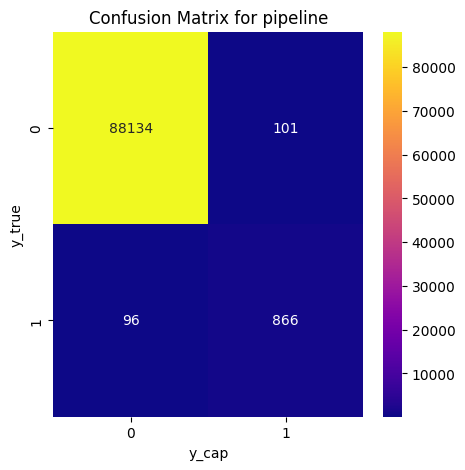

0.9495316148628327
0.8955532574974147
0.9002079002079002


In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, precision_score, recall_score
print(classification_report(y, y_cap))
conf_mat = confusion_matrix(y, y_cap)
plt.figure(figsize = (5,5))
sns.heatmap(conf_mat, annot = True,fmt = 'd', cmap = 'plasma')
plt.title(f'Confusion Matrix for pipeline')
plt.xlabel('y_cap')
plt.ylabel('y_true')
plt.show()
print(roc_auc_score(y, y_cap))
print(precision_score(y, y_cap))
print(recall_score(y, y_cap))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     88235
           1       0.99      0.76      0.86       962

    accuracy                           1.00     89197
   macro avg       0.99      0.88      0.93     89197
weighted avg       1.00      1.00      1.00     89197



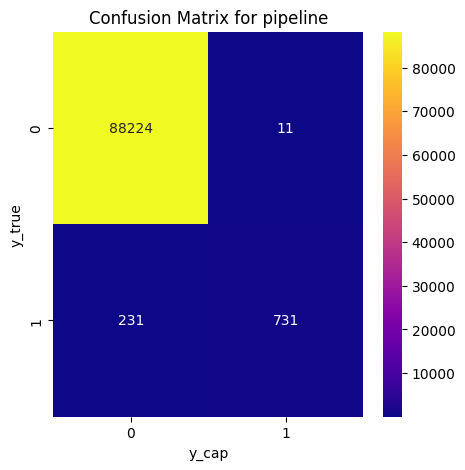

0.8798752963965181
0.9851752021563343
0.7598752598752598


In [ ]:
y_cap = global_pred
print(classification_report(y, y_cap))
conf_mat = confusion_matrix(y, y_cap)
plt.figure(figsize = (5,5))
sns.heatmap(conf_mat, annot = True,fmt = 'd', cmap = 'plasma')
plt.title(f'Confusion Matrix for pipeline')
plt.xlabel('y_cap')
plt.ylabel('y_true')
plt.show()
print(roc_auc_score(y, y_cap))
print(precision_score(y, y_cap))
print(recall_score(y, y_cap))

# Experiment